In [1]:
import copy

import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
from sklearn import preprocessing
import glob
from skimage.measure import block_reduce
import tqdm.notebook
from datetime import datetime
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')
import src.utils
from src.utils import set_gpytorch_settings
set_gpytorch_settings(False)
# Kernel Imports
from gpytorch.kernels import PeriodicKernel
from src.custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.kernels.keops import MaternKernel as FastMaternKernel
from gpytorch.kernels.keops import RBFKernel as FastRBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval, GreaterThan
import itertools
# from gpytorch.metrics import mean_standardized_log_loss, quantile_coverage_error, mean_squared_error, mean_absolute_error
from src.custom_kernel import noise_lower, noise_upper, noise_init

['/home/dcaos/PycharmProjects/GaussProcesses/notebooks', '/home/dcaos/PycharmProjects/GaussProcesses', '/home/dcaos/anaconda3/lib/python310.zip', '/home/dcaos/anaconda3/lib/python3.10', '/home/dcaos/anaconda3/lib/python3.10/lib-dynload', '', '/home/dcaos/.local/lib/python3.10/site-packages', '/home/dcaos/anaconda3/lib/python3.10/site-packages', '/home/dcaos/anaconda3/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/dcaos/anaconda3/lib/python3.10/site-packages/mpmath-1.2.1-py3.10.egg', '/home/dcaos/PycharmProjects/GaussProcesses']


In [2]:
# Reading data file and cleaning missing values
df = pd.read_feather('../Data/feather/46221_9999_wave_height.feather')
parameters_wave = ['time', 'wave_height']
parameters_temp = ['time', 'sea_surface_temperature']
df_as_np = df \
    .loc[:, parameters_wave] \
    .astype(float) \
    .replace(to_replace = [999.0, 99.0, 9999.0], value = np.nan) \
    .to_numpy()
using_sk = block_reduce(df_as_np, block_size=(24,1), func=np.mean).astype(float)
X = torch.tensor(using_sk[:-1,0]).float().cuda()
y = torch.tensor(using_sk[:-1,1]).float().cuda()
X = X.reshape(-1,1)
y = y.reshape(-1,1)

X = X[~torch.any(y.isnan(), dim=1)]
y = y[~torch.any(y.isnan(), dim=1)]
y = y.flatten()
X_old = X


In [3]:
# Helper functions
def period_print(x, scale_factor_value):
    print(f"raw: {x}")
    print(f"seconds: {x * scale_factor_value}")
    print(f"minutes: {x * scale_factor_value / 60}")
    print(f"hours: {x * scale_factor_value / 60 / 60 }")
    print(f"days: {x * scale_factor_value / 60 / 60 / 24}")
    print(f"weeks: {x * scale_factor_value / 60 / 60 / 24 / 7}")
    print(f"months: {x * scale_factor_value / 60 / 60 / 24 / 30}")
    print(f"years: {x * scale_factor_value / 60 / 60 / 24 / 365}")

def period_convert(x, type_to_convert, scale_factor_val):
    match type_to_convert:
        case "raw":
            return x
        case "seconds":
            return x * scale_factor_val
        case "minutes":
            return x * scale_factor_val / 60
        case "hours":
            return x * scale_factor_val / 60 / 60
        case "days":
            return x * scale_factor_val / 60 / 60 / 24
        case "weeks":
            return x * scale_factor_val / 60 / 60 / 24 / 7
        case "months":
            return x * scale_factor_val / 60 / 60 / 24 / 30
        case "years":
            return x * scale_factor_val / 60 / 60 / 24 / 365

def period_convert_list(li, type_to_convert, scale_factor_val):
    converted_list = []
    for h in li:
        converted_list.append(period_convert(h, type_to_convert, scale_factor_val))
    return converted_list

def scaler(a, X_old=X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)

def make_kernel(name_of_kernel):
    if name_of_kernel == 'RBF':
        return RBFKernel(
            lengthscale_constraint=GreaterThan(
                0.00035
            )
        )
    if name_of_kernel.startswith('Mat'):
        nu_value = float(name_of_kernel[-3:])
        return MaternKernel(lengthscale_constraint=GreaterThan(
                0.00035
            ), nu=nu_value)
    if name_of_kernel == 'AR2':
        return AR2Kernel(
            period_constraint=Interval(
                lower_bound=1e-4, upper_bound=0.005),
            lengthscale_constraint=GreaterThan(
                0.00035
            ))
    if name_of_kernel.startswith('Per'):
        if name_of_kernel.startswith('Per_Arb'):
            return PeriodicKernel(
                period_length_constraint=Interval(
                    lower_bound=1e-4, upper_bound=0.75))
        elif name_of_kernel == 'Per_Week':
            return PeriodicKernel(
                period_length_constraint=Interval(
                    lower_bound=1e-4, upper_bound=0.75,
                initial_value=scaler(60*60*24*7, center=False)))
        elif name_of_kernel == 'Per_Month':
            return PeriodicKernel(
                period_length_constraint=Interval(
                    lower_bound=1e-4, upper_bound=0.75,
                initial_value=scaler(60*60*24*30, center=False)))
    else:
        raise ValueError('Kernel not found')

def descaler(a, X_old=X_old, center=True):
    if center is True:
        a = a * (X_old.max(0).values - X_old.min(0).values)
    return a + X_old.min(0).values

# GP Model Declaration
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



Scale Max: 1677108352.0
 Scale Min: 1349069952.0
 Scale Factor: 328038400.0
Before Block Reduce: (174818, 2)
After Block Reduce: (7285, 2)
Number of Nans: 0
Start Time: 2012-09-30 16:55:44
End Time: 2023-02-22 23:25:52
Number of Days: 3642.0416666666665
Time Period (Days): 3797.312592592593


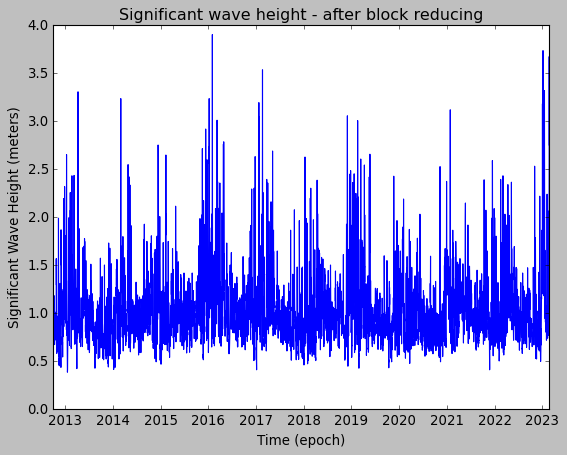

In [4]:
from numpy.ma import indices

# Scale the time axis and log transform the Y-values
X = scaler(X, X_old)
y = y.log()

# max, min, and scale factor declaration
scaler_max = X_old.max(0).values.item()
scaler_min = X_old.min(0).values.item()
scale_factor = scaler_max - scaler_min
print(f'Scale Max: {scaler_max}\n Scale Min: {scaler_min}\n Scale Factor: {scale_factor}')
temp_for_plotting = pd.Series(using_sk[:-1,0]*1e9, dtype='datetime64[ns]')
plt.plot(temp_for_plotting, using_sk[:-1,1])
# plt.plot(y.cpu().numpy())
# print(y)
plt.xlabel("Time (epoch)")
plt.ylabel("Significant Wave Height (meters)")
plt.title(f'Significant wave height - after block reducing')

print(
    f'Before Block Reduce: {df_as_np.shape}\n'
    f'After Block Reduce: {using_sk.shape}\n'
    f'Number of Nans: {np.count_nonzero(np.isnan(df_as_np))}\n'
    f'Start Time: {datetime.fromtimestamp(df_as_np[0,0])}\n'
    f'End Time: {datetime.fromtimestamp(df_as_np[-1,0])}\n'
    f'Number of Days: {df_as_np.shape[0]/48}\n'
    f'Time Period (Days): {(df_as_np[-1,0] - df_as_np[0,0]) / 24 / 60 / 60}')

# Prediction range, training and test set define
predict_days_out = 14
test_n = 2*predict_days_out
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = src.utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [5]:
# List of possible Kernels terms
# Long-term dependence
smooth_kernel_list_t1 = ['RBF']#'', '', '', '']#, 'Mat0.5', 'Mat1.5', 'Mat2.5']
# Medium-term dependence
smooth_kernel_list_t2 = ['Mat2.5']#, 'Mat2.5']#['RBF', 'Mat0.5', 'Mat1.5',
# Fixed Monthly Period
periodic_kernel_list_t3 = ['Per_Month']
# Cyclic period
smooth_kernel_list_t4 = ['RBF']#, 'Mat0.5', 'Mat1.5', 'Mat2.5']
periodic_kernel_list_t4 = ['Per_Arb']#['Per_Arb', 'Per_Week',

periodic_kernel_list_tn = ['RBF', 'Per_Arb', 'Per_Arb', 'Per_Arb', 'Per_Arb', 'Per_Arb','', '', '', '', '', '', '']

baseline_kernel_list = []
for i in itertools.product(*[smooth_kernel_list_t1, smooth_kernel_list_t2, periodic_kernel_list_t3, periodic_kernel_list_t4, smooth_kernel_list_t4]):
    baseline_kernel_list.append(i)

n_kernel_list = []
for i in itertools.combinations(periodic_kernel_list_tn, r=6):
    n_kernel_list.append(i)
n_k_l = list(pd.DataFrame(n_kernel_list).drop_duplicates(keep='first').iloc[:6, :].itertuples(index=False, name=None))
n_k_l.reverse()
# print(n_k_l)

Using available CUDA


Training_exactGP0:   0%|          | 0/1000 [00:00<?, ?it/s]

1 0.8080849647521973
2 0.8049872517585754
3 0.8018864989280701
4 0.7987826466560364
5 0.7956756353378296
6 0.7925657033920288
7 0.789452314376831
8 0.7863361239433289
9 0.7832169532775879
10 0.7800948619842529
11 0.7769694924354553
12 0.773841142654419
13 0.7707102298736572
14 0.7675763964653015
15 0.7644397020339966
16 0.7612999677658081
17 0.7581578493118286
18 0.7550128102302551
19 0.7518652677536011
20 0.7487154603004456
21 0.7455626726150513
22 0.7424080967903137
23 0.739250898361206
24 0.7360914945602417
25 0.7329303026199341
26 0.7297667860984802
27 0.7266014218330383
28 0.7234342098236084
29 0.72026526927948
30 0.7170947790145874
31 0.7139227986335754
32 0.7107494473457336
33 0.7075749635696411
34 0.7043991684913635
35 0.7012224197387695
36 0.6980447769165039
37 0.6948662996292114
38 0.6916875839233398
39 0.6885079145431519
40 0.6853280663490295
41 0.6821479797363281
42 0.6789680123329163
43 0.6757880449295044
44 0.6726083159446716
45 0.6694291234016418
46 0.6662502884864807
47

Training_exactGP1:   0%|          | 0/1000 [00:00<?, ?it/s]

1 0.807858943939209
2 0.8044314980506897
3 0.8010198473930359
4 0.7976341843605042
5 0.7942838072776794
6 0.7909771203994751
7 0.7877182960510254
8 0.7845051288604736
9 0.7813332080841064
10 0.7781892418861389
11 0.7750598192214966
12 0.7719321250915527
13 0.7687962055206299
14 0.7656444311141968
15 0.762475311756134
16 0.7592881321907043
17 0.7560864686965942
18 0.7528725266456604
19 0.7496511340141296
20 0.7464255690574646
21 0.7432005405426025
22 0.7399793863296509
23 0.7367631196975708
24 0.733552873134613
25 0.7303473949432373
26 0.7271460294723511
27 0.7239446640014648
28 0.720740020275116
29 0.7175310254096985
30 0.7143157124519348
31 0.7110934853553772
32 0.7078659534454346
33 0.7046343088150024
34 0.7013997435569763
35 0.6981639862060547
36 0.6949300169944763
37 0.6916976571083069
38 0.6884661316871643
39 0.685235857963562
40 0.682006299495697
41 0.6787754893302917
42 0.6755433082580566
43 0.6723083853721619
44 0.6690728068351746
45 0.6658350825309753
46 0.6625962257385254
47 

Training_exactGP2:   0%|          | 0/1000 [00:00<?, ?it/s]

1 0.8082919120788574
2 0.804862916469574
3 0.8014482259750366
4 0.7980557680130005
5 0.7946951389312744
6 0.7913767099380493
7 0.7881050705909729
8 0.7848811745643616
9 0.7817001938819885
10 0.7785509824752808
11 0.7754197120666504
12 0.7722902894020081
13 0.7691516280174255
14 0.765998899936676
15 0.7628267407417297
16 0.7596357464790344
17 0.7564285397529602
18 0.7532095909118652
19 0.7499814629554749
20 0.746749758720398
21 0.743519127368927
22 0.7402920126914978
23 0.7370707988739014
24 0.7338563203811646
25 0.7306471467018127
26 0.727441132068634
27 0.7242355346679688
28 0.7210274934768677
29 0.7178143262863159
30 0.714595377445221
31 0.7113677859306335
32 0.7081356048583984
33 0.7048988938331604
34 0.7016592621803284
35 0.6984187960624695
36 0.6951802372932434
37 0.6919450163841248
38 0.6887092590332031
39 0.6854764819145203
40 0.6822435259819031
41 0.679008960723877
42 0.6757726669311523
43 0.6725354194641113
44 0.669294536113739
45 0.6660533547401428
46 0.6628124713897705
47 0.

Training_exactGP3:   0%|          | 0/1000 [00:00<?, ?it/s]

1 0.808576226234436
2 0.8051509261131287
3 0.8017354011535645
4 0.798340380191803
5 0.7949745059013367
6 0.7916473150253296
7 0.7883703708648682
8 0.7851381897926331
9 0.7819533944129944
10 0.7787994742393494
11 0.7756683826446533
12 0.7725387811660767
13 0.769403338432312
14 0.7662504315376282
15 0.7630773186683655
16 0.7598839402198792
17 0.7566752433776855
18 0.7534523010253906
19 0.7502232193946838
20 0.7469892501831055
21 0.7437537312507629
22 0.7405229806900024
23 0.7372985482215881
24 0.7340821623802185
25 0.7308707237243652
26 0.7276604771614075
27 0.7244515419006348
28 0.7212411165237427
29 0.7180271148681641
30 0.7148051261901855
31 0.7115770578384399
32 0.7083435654640198
33 0.7051050066947937
34 0.7018653750419617
35 0.6986229419708252
36 0.6953812837600708
37 0.6921411156654358
38 0.6889052391052246
39 0.6856684684753418
40 0.682432234287262
41 0.6791970729827881
42 0.6759588122367859
43 0.6727175116539001
44 0.6694759726524353
45 0.6662335395812988
46 0.6629889607429504
4

Training_exactGP4:   0%|          | 0/1000 [00:00<?, ?it/s]

1 0.8087891936302185
2 0.8053647875785828
3 0.80195152759552
4 0.798553466796875
5 0.7951868772506714
6 0.7918570637702942
7 0.7885705232620239
8 0.7853369116783142
9 0.7821471691131592
10 0.7789902687072754
11 0.7758563756942749
12 0.7727261781692505
13 0.7695911526679993
14 0.7664393186569214
15 0.7632660269737244
16 0.760071873664856
17 0.756862223148346
18 0.753638744354248
19 0.7504081130027771
20 0.7471712827682495
21 0.7439334988594055
22 0.7407023310661316
23 0.7374783754348755
24 0.7342590689659119
25 0.7310464382171631
26 0.7278340458869934
27 0.7246242165565491
28 0.7214123010635376
29 0.7181946039199829
30 0.7149693965911865
31 0.7117373943328857
32 0.7085021138191223
33 0.7052650451660156
34 0.7020223140716553
35 0.6987805366516113
36 0.6955376863479614
37 0.6922980546951294
38 0.6890580058097839
39 0.6858206391334534
40 0.6825835704803467
41 0.6793442964553833
42 0.6761049628257751
43 0.672863245010376
44 0.6696187257766724
45 0.666374921798706
46 0.6631273031234741
47 0.

Training_exactGP5:   0%|          | 0/1000 [00:00<?, ?it/s]

1 0.8089614510536194
2 0.8055363893508911
3 0.8021219372749329
4 0.7987259030342102
5 0.7953578233718872
6 0.7920255064964294
7 0.7887369990348816
8 0.7854957580566406
9 0.7823036909103394
10 0.7791454195976257
11 0.7760100364685059
12 0.7728829979896545
13 0.7697513103485107
14 0.7665984630584717
15 0.7634273767471313
16 0.7602365612983704
17 0.7570278644561768
18 0.7538048028945923
19 0.7505708336830139
20 0.7473320960998535
21 0.7440924644470215
22 0.7408550977706909
23 0.7376255393028259
24 0.7344026565551758
25 0.7311878204345703
26 0.7279775738716125
27 0.7247689962387085
28 0.7215574383735657
29 0.7183412313461304
30 0.7151193022727966
31 0.7118898034095764
32 0.7086508274078369
33 0.705409586429596
34 0.7021629214286804
35 0.6989167332649231
36 0.6956690549850464
37 0.692429780960083
38 0.6891920566558838
39 0.6859530806541443
40 0.68271803855896
41 0.6794810891151428
42 0.6762399673461914
43 0.6729971170425415
44 0.6697532534599304
45 0.6665089130401611
46 0.6632626056671143
4

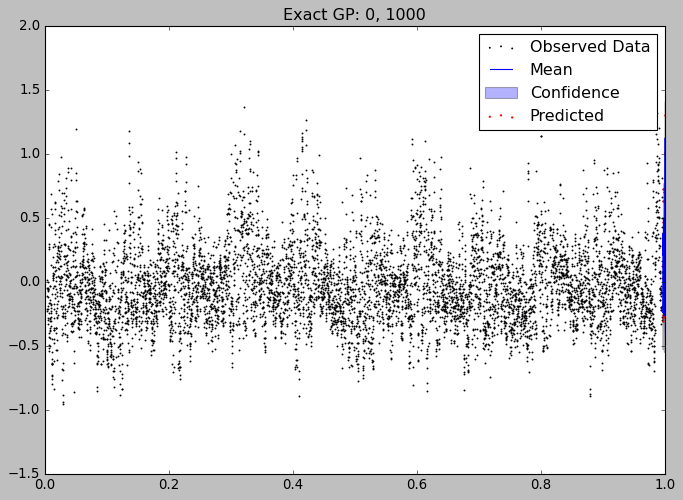

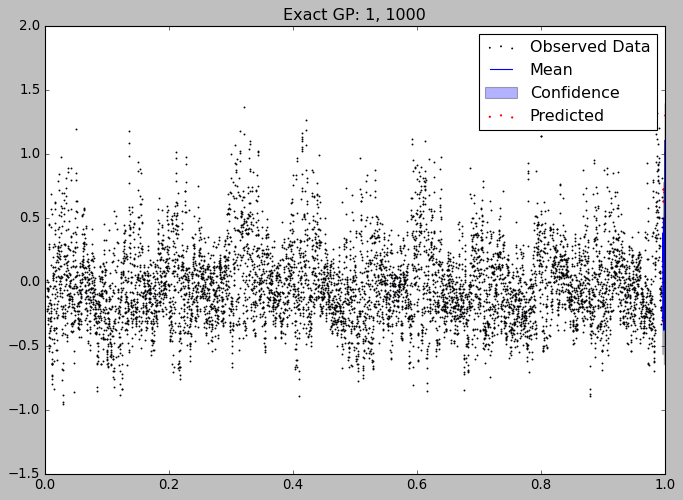

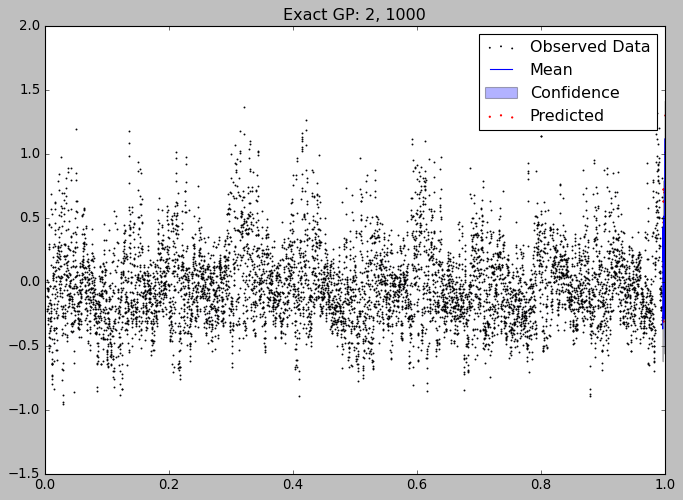

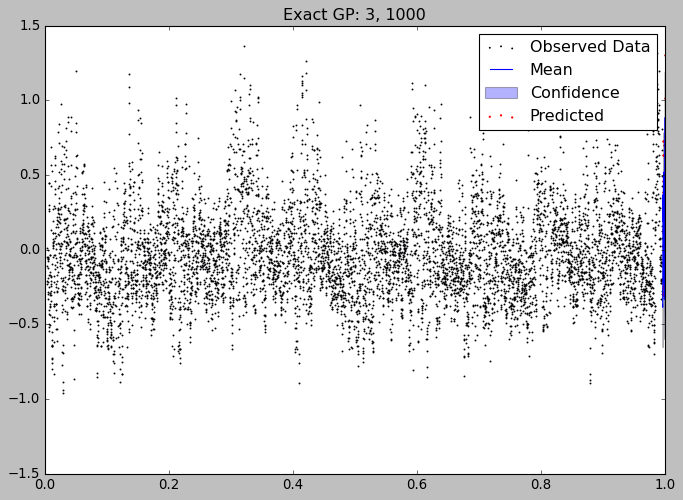

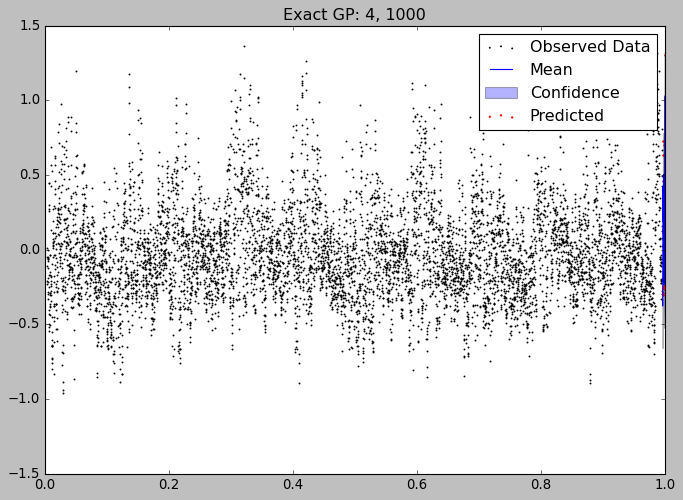

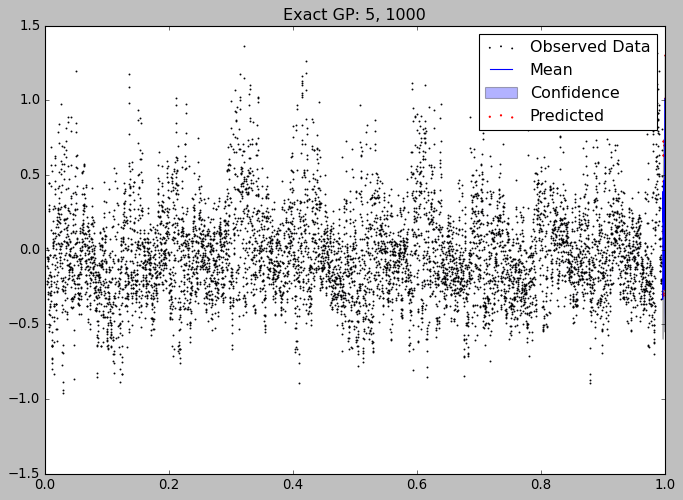

In [6]:
# Initializing empty list to record values
bic_save = []
n = 0
lr_check = 0.01#0.0063
for k_i in n_k_l:
    kernel = ScaleKernel(copy.deepcopy(make_kernel(k_i[0])))
    for t_i in list(k_i)[1:]:
        if t_i == '':
            break
        kernel = kernel + (ScaleKernel(copy.deepcopy(make_kernel(t_i))))
    # sk1, sk2, pk1, pk2, sk3 = k_i
    # kernel = ScaleKernel(make_kernel(sk1)) + ScaleKernel(make_kernel(sk2)) + ScaleKernel(make_kernel(pk1)) + ScaleKernel(make_kernel(pk2) * make_kernel(sk3))
    # kernel_name = f'{sk1}plus{sk2}plus{pk1}plus{sk3}x{pk2}_exact_gp'
    # k_list = [str(sk1), str(sk2), str(pk1), str(pk2), str(sk3)]
    kernel_name = str(n)
    exact_gp = src.utils.TrainTestPlotSaveExactGP(
        ExactGPModel, kernel,
        train_x, train_y, test_x, test_y,
        num_iter=1000, lr=lr_check, #lr=0.0063, #lr=0.01,
        name=kernel_name, print_values=True)
    exact_gp.test_eval_exact_gp()
    exact_gp.plot(show_plot=False)
    bic_value = exact_gp.get_BIC()
    hyper_values = []
    output_scale = []
    if n == 0:
        output_scale.append([kernel.outputscale.item()])
    else:
        output_scale.append([kernel.kernels[0].outputscale.item()])
    for pk in range(n+1):
        print(pk)
        if pk == 0:
            hyper_values.append([-9999])
        else:
            hyper_values.append([kernel.kernels[pk].base_kernel.period_length.item()])
            output_scale.append([kernel.kernels[pk].outputscale.item()])


        # kernel.kernels[0].base_kernel.lengthscale.item(),
        # kernel.kernels[1].base_kernel.lengthscale.item(),
        # kernel.kernels[2].base_kernel.lengthscale.item(),
        # kernel.kernels[2].base_kernel.period_length.item(),
        # kernel.kernels[3].base_kernel.kernels[0].lengthscale.item(),
        # kernel.kernels[3].base_kernel.kernels[0].period_length.item(),
        # kernel.kernels[3].base_kernel.kernels[1].lengthscale.item(),]
    bic_save.append([
        kernel_name,
        n,
        bic_value.item(),
        hyper_values,
        output_scale,
        kernel])
        #period_convert_list(hyper_values, "days", scale_factor),])
        # *hyper_values,
        # *k_i])
    print("Learning Rate: ", lr_check)
    print("Kernel Structure: ", *k_i)
    print("BIC: ", exact_gp.get_BIC().item())
    print("Iterations Number(n): ",n)
    print("Hyper Values: ", hyper_values)
    print("Output Scale Values: ", output_scale)
    print("Memory Check: ", torch.cuda.mem_get_info(device=None))
    n += 1
    # lr_check += 0.0001
    del exact_gp
    del kernel
    gc.enable()
    gc.collect()
    torch.cuda.empty_cache()
column_names = [
        'Kernel_Name','n', 'BIC', 'Period_Length_(days)', 'Output_Scale', 'kernel_full']
        # 's1_ls_converted', 's2_ls_converted','pk1_ls_converted', 'pk1_pr_converted', 'pk2_ls_converted', 'pk2_pr_converted', 's3_ls_converted',
        # 's1_ls_raw', 's2_ls_raw', 'pk1_ls_raw', 'pk1_pr_raw', 'pk2_ls_raw', 'pk2_pr_raw','s3_ls_raw',
        # 'add_scale1_K1', 'add_scale2_K2', 'add_period1_K3', 'scale3_mult_K4', 'scale3_mult_K4']
bic_out_df = pd.DataFrame(
    bic_save, columns=column_names)
bic_out_df.to_csv('bic_save_linear_kernel_struct_baseline.csv')

In [7]:

bic_out_df.to_csv("additive_kernel_failed_repeating_kernel_value.csv")
#bic_out_df["kernel_full"][3].kernels
bic_out_df

,Kernel_Name,n,BIC,Period_Length_(days),Output_Scale,kernel_full
0,0,0,-2074.045166,[[-9999]],[[0.0833149254322052]],ScaleKernel(\n (base_kernel): RBFKernel(\n ...
1,1,1,-2110.156006,"[[-9999], [0.41007760167121887]]","[[0.07376830279827118], [0.0031540750060230494]]",AdditiveKernel(\n (kernels): ModuleList(\n ...
2,2,2,-2096.096191,"[[-9999], [0.3878316283226013], [0.38783162832...","[[0.07400627434253693], [0.003956361208111048]...",AdditiveKernel(\n (kernels): ModuleList(\n ...
3,3,3,-2073.449219,"[[-9999], [0.38826635479927063], [0.3882663547...","[[0.07588258385658264], [0.002294593257829547]...",AdditiveKernel(\n (kernels): ModuleList(\n ...
4,4,4,-2038.364746,"[[-9999], [0.3890054523944855], [0.38900545239...","[[0.07764540612697601], [0.001909629674628377]...",AdditiveKernel(\n (kernels): ModuleList(\n ...
5,5,5,-2062.644775,"[[-9999], [0.3890113830566406], [0.38901138305...","[[0.07586713135242462], [0.0018583888886496425...",AdditiveKernel(\n (kernels): ModuleList(\n ...


In [8]:
bic_out_df.iloc[:, 2:-1].to_latex()
bic_out_df.iloc[:, 2:-1].to_latex(float_format="%.4f")



/tmp/ipykernel_39506/1756904919.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  bic_out_df.iloc[:, 2:-1].to_latex()
/tmp/ipykernel_39506/1756904919.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  bic_out_df.iloc[:, 2:-1].to_latex(float_format="%.4f")


'\\begin{tabular}{lrll}\n\\toprule\n{} &        BIC &                               Period\\_Length\\_(days) &                                       Output\\_Scale \\\\\n\\midrule\n0 & -2074.0452 &                                          [[-9999]] &                             [[0.0833149254322052]] \\\\\n1 & -2110.1560 &                   [[-9999], [0.41007760167121887]] &   [[0.07376830279827118], [0.0031540750060230494]] \\\\\n2 & -2096.0962 &  [[-9999], [0.3878316283226013], [0.38783162832... &  [[0.07400627434253693], [0.003956361208111048]... \\\\\n3 & -2073.4492 &  [[-9999], [0.38826635479927063], [0.3882663547... &  [[0.07588258385658264], [0.002294593257829547]... \\\\\n4 & -2038.3647 &  [[-9999], [0.3890054523944855], [0.38900545239... &  [[0.07764540612697601], [0.001909629674628377]... \\\\\n5 & -2062.6448 &  [[-9999], [0.3890113830566406], [0.38901138305... &  [[0.07586713135242462], [0.0018583888886496425... \\\\\n\\bottomrule\n\\end{tabular}\n'

In [9]:
period_print(0.000329, scale_factor)
# print(len(bic_save[0]))
# bic_save
# gc.enable()
# gc.collect()
# torch.cuda.empty_cache()
# torch.cuda.CUDAGraph().pool()

# baseline_df_master = pd.read_csv('Baseline_Kernel_Results.csv', index_col='BIC')
# baseline_df_master.to_csv('Baseline_Kernel_Results_bak.csv')
# # baseline_df_master = baseline_df_master.reset_index()
# baseline_df_master



# joined_baseline_df = pd.merge(right=baseline_df_master, left=bic_out_df, on='BIC', how='outer')
# pd.concat([baseline_df_master, bic_out_df], ignore_index=True)
# joined_baseline_df.to_csv('Baseline_Kernel_Results.csv')
# joined_baseline_df
# temp_list = []
# temp_list.append([*period_convert_list(hyper_values, "days", scale_factor)])
# temp_list


# print(bic_out_df["kernel_full"][3].kernels[0].outputscale.item(),
#     bic_out_df["kernel_full"][3].kernels[1].outputscale.item(),
#     bic_out_df["kernel_full"][3].kernels[2].outputscale.item(),
#     bic_out_df["kernel_full"][3].kernels[2].outputscale.item(),)
# print(bic_out_df["kernel_full"][3].kernels[0].outputscale.item()+bic_out_df["kernel_full"][3].kernels[2].outputscale.item())



# kernel.outputscale
# kernel.kernels[2].base_kernel.lengthscale.item(),

# for i in itertools.accumulate(periodic_kernel_list_tn, operator.add):
#     print(i)
# l1 = (['abc', 'def'])
# l2 = ['123', '456']
# l3 = ['---', 'xxx']
# list_of_lists = [l1, l2, l3]
# l4 = np.array([['rbf']])
# # for i in itertools.product(zip(smooth_kernel_list_t1, smooth_kernel_list_t2, periodic_kernel_list_t3, smooth_kernel_list_t4, periodic_kernel_list_t4)):
# for i in itertools.product(*[l1, l2, l3]):#*zip(l1, l2, l3)):
# # for i in itertools.product(*[smooth_kernel_list_t1, smooth_kernel_list_t2, periodic_kernel_list_t3, smooth_kernel_list_t4, periodic_kernel_list_t4]):
#     print(i, ": ")
#     print(i[1])
# # plt.plot(bic_out_df['BIC'])
# # vector_i = np.array([[1, 1, 1, 0]]).T
# # [a*b for a,b in zip(vector_i, l4)]
# # np.dot(vector_i, l4)
# kernel

# two_term_results = pd.read_csv("joined_results_4_7.csv")
# merged_df = pd.merge(bic_out_df, two_term_results, how="outer")
# merged_df.to_csv('merged_csv_messy.csv')
# merged_df

# kernel
# torch.cuda.current_device()
.0003**2

raw: 0.000329
seconds: 107924.63359999999
minutes: 1798.743893333333
hours: 29.979064888888885
days: 1.2491277037037036
weeks: 0.1784468148148148
months: 0.04163759012345679
years: 0.00342226768138001


8.999999999999999e-08